# Working with Custom Images

We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches.


## Importing

In [1]:
import matplotlib.pyplot as plt
import cv2

## Visualizing the Data

Data source: https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

### Cat image example

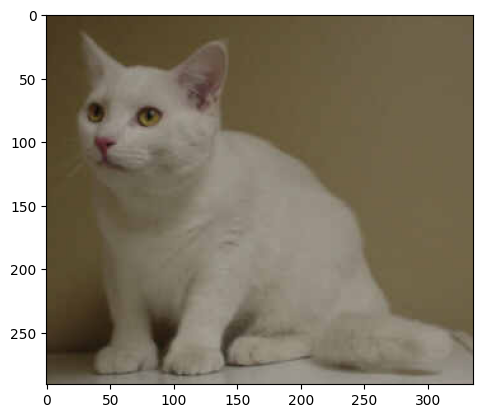

In [2]:
cat = cv2.imread("../DATA/catsanddogs/train/CAT/57.jpg")
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.imshow(cat)

### Dog image example

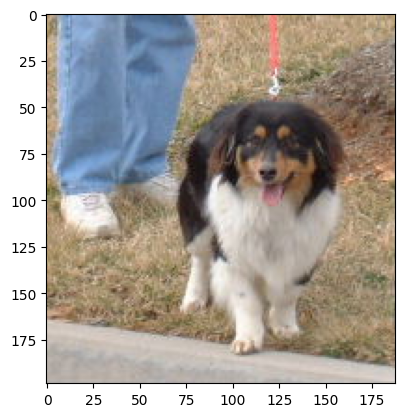

In [3]:
dog = cv2.imread("../DATA/catsanddogs/train/DOG/2.jpg")
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
plt.imshow(dog)

## Preparing the Data for the Model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the ImageDataGenerator to do this automatically for us.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale=1/255, # Rescale the image by normalizing it.
                               rotation_range=30, # Rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

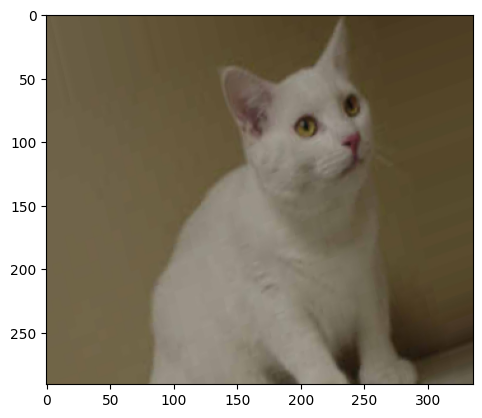

In [5]:
plt.imshow(image_gen.random_transform(cat))

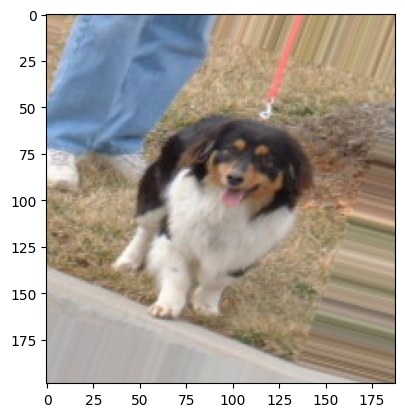

In [6]:
plt.imshow(image_gen.random_transform(dog))

### Generate many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

### Resize Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

In [7]:
image_shape = (150, 150, 3)

## Creating the Model

In [8]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3 ,3), input_shape=(150, 150, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(150, 150, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(150, 150, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

## Training the Model

In [9]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory("../DATA/catsanddogs/train",
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode="binary")

test_image_gen = image_gen.flow_from_directory("../DATA/catsanddogs/test",
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode="binary")

Found 18743 images belonging to 2 classes.
Found 6251 images belonging to 2 classes.


In [10]:
import warnings
warnings.filterwarnings("ignore")

results = model.fit_generator(train_image_gen,
                              epochs=4, # 100 should be fine, but it takes forever to train
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                              validation_steps=12)

Epoch 1/4


2023-02-26 21:11:59.866950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


150/150 [==============================] - 34s 227ms/step - loss: 0.6982 - accuracy: 0.4833 - val_loss: 0.6926 - val_accuracy: 0.5052
Epoch 2/4
150/150 [==============================] - 34s 227ms/step - loss: 0.6921 - accuracy: 0.5258 - val_loss: 0.6861 - val_accuracy: 0.5521
Epoch 3/4
150/150 [==============================] - 34s 224ms/step - loss: 0.6896 - accuracy: 0.5608 - val_loss: 0.6904 - val_accuracy: 0.5156
Epoch 4/4
150/150 [==============================] - 33s 218ms/step - loss: 0.6856 - accuracy: 0.5671 - val_loss: 0.6746 - val_accuracy: 0.5677


## Evaluating the Model

In [11]:
results.history["accuracy"]

[0.4833333194255829,
 0.5258333086967468,
 0.5608333349227905,
 0.5670833587646484]

## Predicting on New Images

In [12]:
import numpy as np
import keras.utils as image

dog_file = "../DATA/catsanddogs/test/DOG/9876.jpg"

dog_img = image.load_img(dog_file, target_size=(150, 150))
dog_img = image.img_to_array(dog_img)
dog_img = np.expand_dims(dog_img, axis=0)
dog_img = dog_img / 255

In [13]:
print(f"Probability that image is a dog is: {model.predict(dog_img)}")

1/1 [==============================] - 0s 73ms/step
Probability that image is a dog is: [[0.52139634]]
